In [ ]:
import pandas as pd

#First out imports
#Lets import some stuff!

#Numpy
import numpy as np

#Cartopy for mapping

from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.plots import StationPlot, StationPlotLayout, simple_layout
from metpy.units import units


#Matplotlib for plotting
import matplotlib.pyplot as plt

#Siphon for finding data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

#date tools
from datetime import datetime, timedelta
from netCDF4 import num2date


import cartopy.crs as ccrs
import cartopy.feature as feat
from matplotlib import rcParams

#os tools
import os

%matplotlib inline

In [2]:
def get_cloud_cover(code):
    if 'OVC' in code:
        return 1.0
    elif 'BKN' in code:
        return 6.0/8.0
    elif 'SCT' in code:
        return 4.0/8.0
    elif 'FEW' in code:
        return 2.0/8.0
    else:
        return 0

In [98]:
def prep_data(pdframe, time_desired):
    pdframe['date'] = pd.to_datetime(pdframe['valid'])
    start_date = time_desired
    end_date = start_date + pd.Timedelta(1, 'h')
    mask = (pdframe['date'] > start_date) & (pdframe['date'] <= end_date)
    asos_data_latest = pdframe[mask]
    df_for_plotting = asos_data_latest.sort_values(by='date', ascending=False)
    groups_for_plotting = df_for_plotting.groupby('station')
    #create a new DataFrame for the most recent values
    df_recent = pd.DataFrame(columns=df_for_plotting.columns)
    #retrieve the first entry for each group, which will
    #be the most recent observation
    for rid, station in groups_for_plotting:
        row = station.head(1)
        df_recent = pd.concat([df_recent, row])

    df_recent = df_recent.replace('M', np.NaN)
    #df_recent = df_recent.convert_objects(convert_numeric=True)
    data = dict()
    data['stid'] = np.array(df_recent["station"])
    data['latitude']  = np.array(df_recent['lat'].astype(float))
    data['longitude'] = np.array(df_recent['lon'].astype(float))
    data['air_temperature'] = (np.array(df_recent['tmpf'].astype(float), dtype=float) -32.0)*(5.0/9.0)* units.degC
    data['dew_point'] = (np.array(df_recent[' dwpf'].astype(float), dtype=float) -32.0)*(5.0/9.0)* units.degC
    data['slp'] = np.array(df_recent[' mslp'].astype(float))* units('mbar')
    u, v = get_wind_components(np.array(df_recent[' sknt'].astype(float)) * units('knots'),
                               np.array(df_recent[' drct'].astype(float)) * units('degree'))
    data['eastward_wind'], data['northward_wind'] = u, v
    data['cloud_frac'] = [int(get_cloud_cover(x)*8) for x in df_recent[' skyc1'].astype(str)]
    return data

In [123]:
asos_data_mass = pd.read_csv('../data/ma-201711.txt')

In [171]:
all_files = ['../data/ny-201711.txt',
             '../data/ma-201711.txt',
             '../data/nh-201711.txt',
             '../data/onca-201711.txt',
             '../data/mn-201711.txt',
             '../data/mi-201711.txt',
             '../data/pa-201711.txt']
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
asos_data = pd.concat(list_)

In [172]:
def plot_that(data, axes, projection, extent = (-90., -65., 35., 50.)):
    state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='50m', facecolor='none')
    # Create the figure
    #add_metpy_logo(fig, 1000, 50, size='small')

    # Add map elements 
    axes.add_feature(feat.LAND, zorder=-1)
    axes.add_feature(feat.OCEAN, zorder=-1)
    axes.add_feature(feat.LAKES, zorder=-1)
    axes.coastlines(resolution='50m', zorder=2, color='black')
    axes.add_feature(state_boundaries)
    axes.add_feature(feat.BORDERS, linewidth=2, edgecolor='black')

    


    # Start the station plot by specifying the axes to draw on, as well as the
    # lon/lat of the stations (with transform). We also set the fontsize to 12 pt.
    stationplot = StationPlot(axes, data['longitude'], data['latitude'],
                              transform=projection, fontsize=12)

    # The layout knows where everything should go, and things are standardized using
    # the names of variables. So the layout pulls arrays out of `data` and plots them
    # using `stationplot`.
    simple_layout.plot(stationplot, data)

    # Plot the temperature and dew point to the upper and lower left, respectively, of
    # the center point. Each one uses a different color.
    stationplot.plot_parameter('NW', np.array(data['air_temperature']), color='red')
    stationplot.plot_parameter('SW', np.array(data['dew_point']), color='darkgreen')

    # A more complex example uses a custom formatter to control how the sea-level pressure
    # values are plotted. This uses the standard trailing 3-digits of the pressure value
    # in tenths of millibars.
    stationplot.plot_parameter('NE', np.array(data['slp']),
                               formatter=lambda v: format(10 * v, '.0f')[-3:])

    # Plot the cloud cover symbols in the center location. This uses the codes made above and
    # uses the `sky_cover` mapper to convert these values to font codes for the
    # weather symbol font.
    stationplot.plot_symbol('C', data['cloud_frac'], sky_cover)

    # Also plot the actual text of the station id. Instead of cardinal directions,
    # plot further out by specifying a location of 2 increments in x and 0 in y.
    stationplot.plot_text((2, 0), np.array(data["stid"]))
    axes.set_extent(extent)


In [173]:
target_time = pd.datetime(2017, 11, 5, 5, 0)
much_data = prep_data(asos_data, target_time)
mass_data = prep_data(asos_data_mass, target_time)

/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/xarray.py:381: MetpyDeprecationWarning: The get_wind_components function was deprecated in version 0.9. This function has been renamed wind_components.
  return func(*args, **kwargs)


/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)


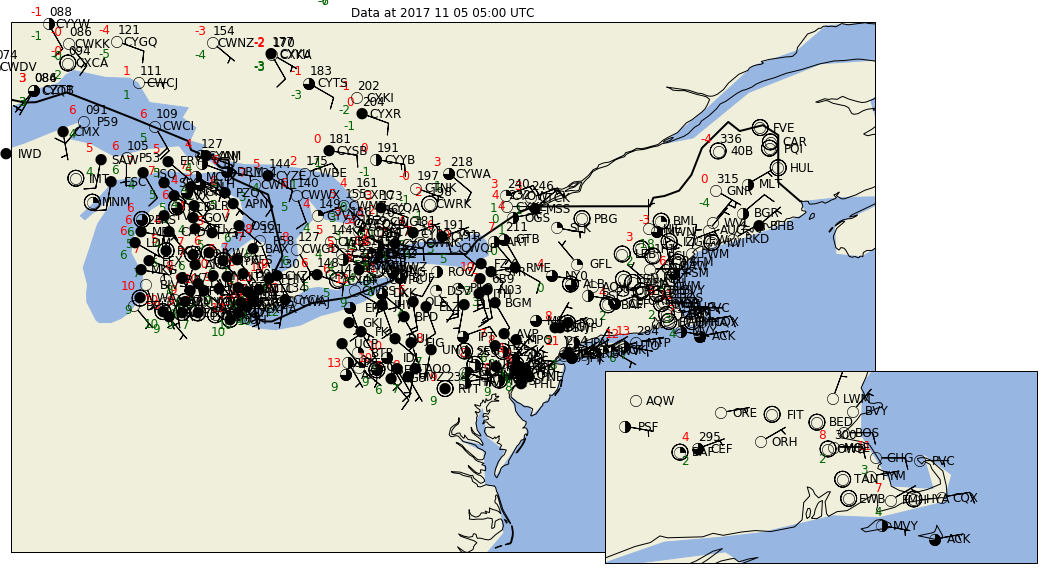

In [174]:
fig = plt.figure(figsize=(15., 10.))
proj = ccrs.PlateCarree()
#ax = fig.add_subplot(1, 1, 1, projection=proj)
ax = fig.add_axes([.1, .1, .8, .9], projection=proj)
plot_that(much_data, ax, proj, extent = (-90., -65., 35., 50.))
plt.title(target_time.strftime('Data at %Y %m %d %H:%M UTC'))

ax2 = fig.add_axes([.65, .1, .4, .4], projection=proj)
plot_that(mass_data, ax2, proj, extent = (-73.5, -69., 41., 43.))

plt.savefig(target_time.strftime('../images/mass_%Y%m%d%H%M.jpg'))

In [175]:
start_time = pd.datetime(2017, 11, 5, 1, 0)
for i in range(72):
    target_time = start_time + pd.Timedelta(i, 'h')
    much_data = prep_data(asos_data, target_time)
    mass_data = prep_data(asos_data_mass, target_time)
    fig = plt.figure(figsize=(15., 10.))
    proj = ccrs.PlateCarree()
    #ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = fig.add_axes([.1, .1, .8, .9], projection=proj)
    plot_that(much_data, ax, proj, extent = (-90., -65., 35., 50.))
    plt.title(target_time.strftime('Data at %Y %m %d %H:%M UTC'))

    ax2 = fig.add_axes([.65, .1, .4, .4], projection=proj)
    plot_that(mass_data, ax2, proj, extent = (-73.5, -69., 41., 43.))

    plt.savefig(target_time.strftime('../images/mass_%Y%m%d%H%M.jpg'))
    plt.close(fig)


/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/xarray.py:381: MetpyDeprecationWarning: The get_wind_components function was deprecated in version 0.9. This function has been renamed wind_components.
  return func(*args, **kwargs)
/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/Users/scollis/anaconda3/envs/pchange/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)


Text(0.5,1,'Boston')

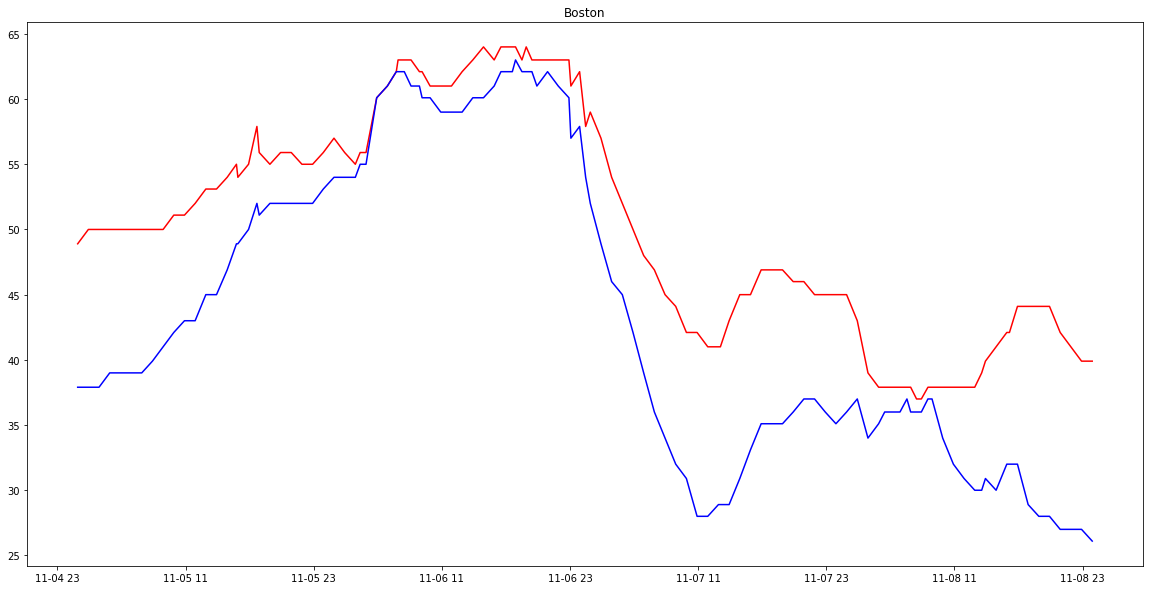

In [168]:
boston = asos_data[asos_data['station'].str.match('BOS')].replace('M', np.NaN)
tempisgd = boston['tmpf'].notnull()

fig = plt.figure(figsize = [20,10])
plt.plot(boston['date'][tempisgd],  boston['tmpf'][tempisgd].astype(float), 'r-')
plt.plot(boston['date'][tempisgd],  boston[' dwpf'][tempisgd].astype(float), 'b-')
plt.title("Boston")


Text(0.5,1,'Beford')

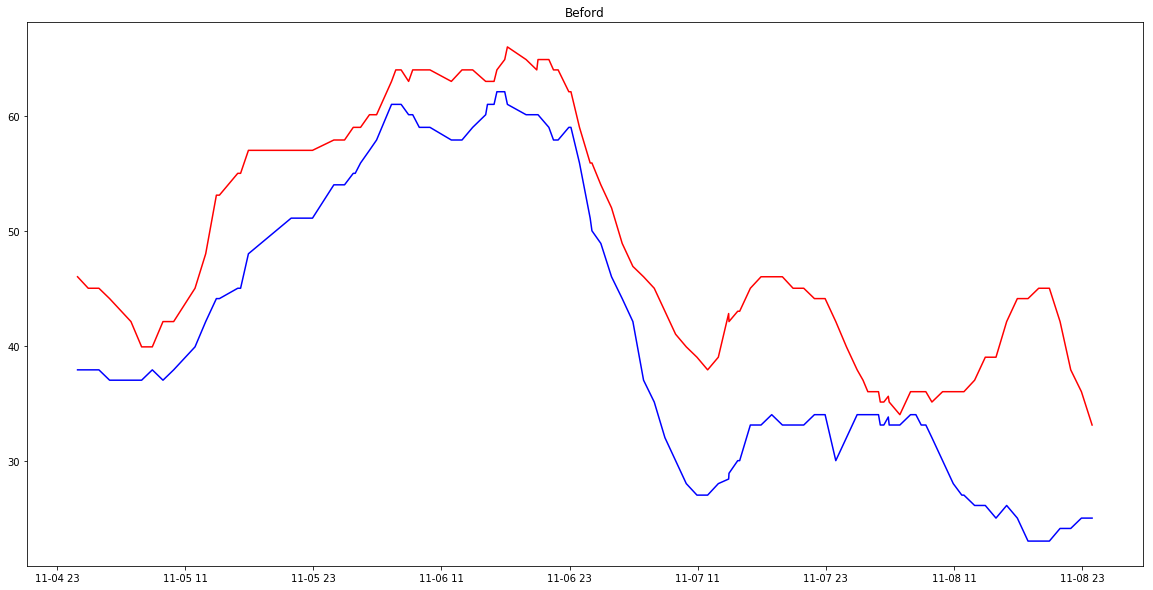

In [169]:
boston = asos_data[asos_data['station'].str.match('BED')].replace('M', np.NaN)
tempisgd = boston['tmpf'].notnull()

fig = plt.figure(figsize = [20,10])
plt.plot(boston['date'][tempisgd],  boston['tmpf'][tempisgd].astype(float), 'r-')
plt.plot(boston['date'][tempisgd],  boston[' dwpf'][tempisgd].astype(float), 'b-')
plt.title("Beford")

Text(0.5,1,'Harriman-and-West Airport')

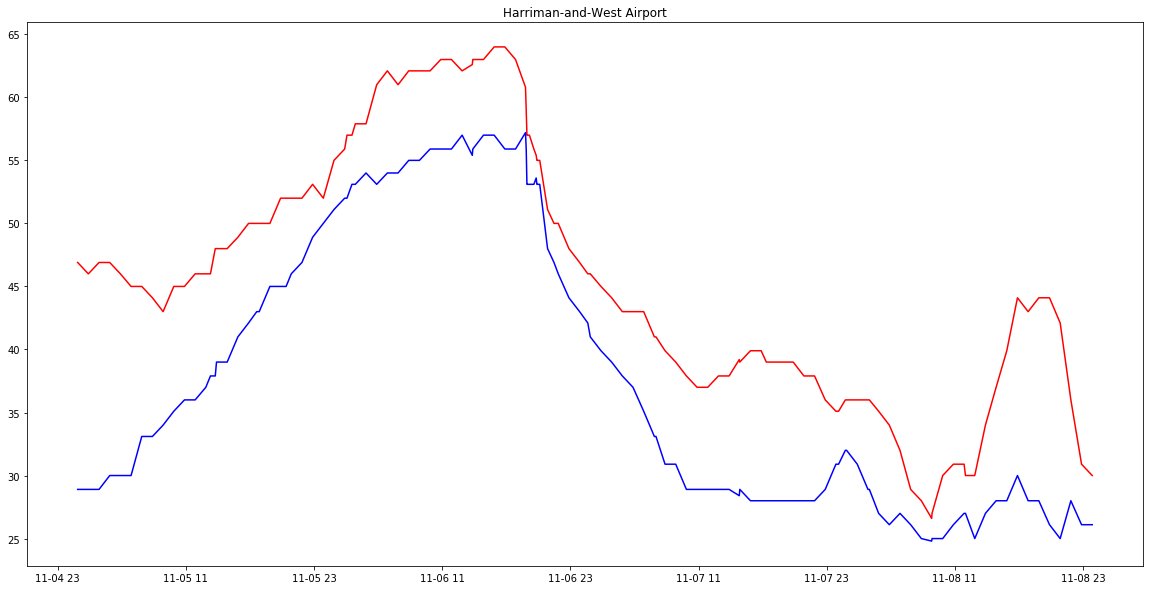

In [170]:
boston = asos_data[asos_data['station'].str.match('AQW')].replace('M', np.NaN)
tempisgd = boston['tmpf'].notnull()

fig = plt.figure(figsize = [20,10])
plt.plot(boston['date'][tempisgd],  boston['tmpf'][tempisgd].astype(float), 'r-')
plt.plot(boston['date'][tempisgd],  boston[' dwpf'][tempisgd].astype(float), 'b-')
plt.title("Harriman-and-West Airport")

In [ ]:
Harriman-and-West Airport